In [1]:
import numpy as np

import matplotlib.pyplot as plt
import time
from keras.preprocessing import image

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
image_data = np.load("image_data64.npy") # load image data
labels = np.load("labels64.npy") # load label data

n_samples, height, width, channels = image_data.shape # dimensions: 24000 images, 64px, 64px, 3 RGB channels (a 4D array)

# construct 2D array
image_data_reshaped = image_data.reshape(n_samples, height * width * channels) # (24000 images, 12288 pixel values of each image as an 1D vector)

# data standardization
scaler = StandardScaler() 
image_data_standardized = scaler.fit_transform(image_data_reshaped)


In [3]:
variance = []
n_components_range = [260,270,280] 

# checking for cumulative variance for the above amounts of principal components
for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(image_data_standardized)
    variance.append(np.sum(pca.explained_variance_ratio_)) 


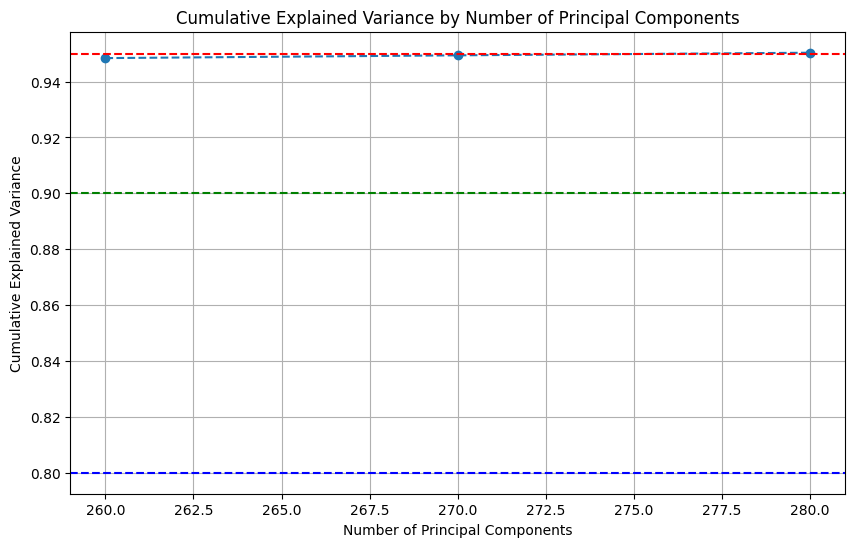

In [4]:
# plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')  # 95% variance line
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')  # 90% variance line
plt.axhline(y=0.80, color='b', linestyle='--', label='80% Explained Variance')  # 80% variance line
plt.show()

Original image data shape: (24000, 12288)
Shape after applying PCA with 280 components: (24000, 280)


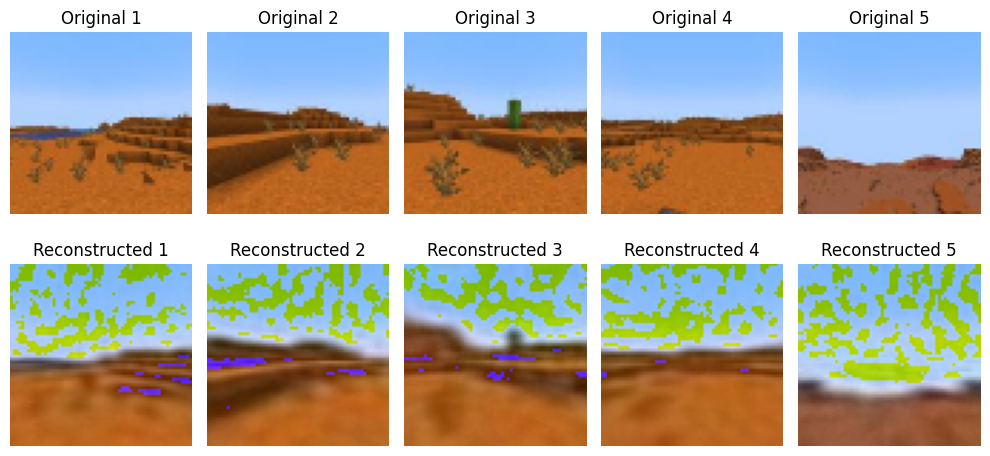

In [5]:
# optimal number of components to reach 95% explained variance
optimal_n_components = next((i for i, v in zip(n_components_range, variance) if v >= 0.95), n_components_range[-1])

# PCA with the optimal number of components, applied to data
pca_optimal = PCA(n_components=optimal_n_components)
image_data_pca = pca_optimal.fit_transform(image_data_standardized)

#Print out the state of the images after PCA
print(f"Original image data shape: {image_data_standardized.shape}")
print(f"Shape after applying PCA with {optimal_n_components} components: {image_data_pca.shape}")


################### just to visualize. how much data is retained after applying pca #################
image_data_reconstructed = pca_optimal.inverse_transform(image_data_pca)
image_data_reconstructed = image_data_reconstructed.reshape(n_samples, height, width, channels)
image_data_reconstructed = scaler.inverse_transform(image_data_reconstructed.reshape(n_samples, -1))
image_data_reconstructed = image_data_reconstructed.reshape(n_samples, height, width, channels)
plt.figure(figsize=(10, 5))

for i in range(5):
    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.uint8(image_data[i]))
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, 5, i + 6)
    plt.imshow(np.uint8(image_data_reconstructed[i]))
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#######################

In [6]:
# Splitting the data into training, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(
    image_data_pca, # features after pca dimension reduction
    labels, # corresponding labels are the same as for image_data
    test_size = 0.15, #15% for  tests 
    random_state=42, # meaning of life, seed for reproducibility
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, # Features
    y_train, # Corresponding labels
    test_size=0.18, # 18% of training data for validation is about 15,3% of the original data
    random_state=42, 
    stratify=y_train
)

print(f"Training set shape: {X_train.shape}, Training labels shape: {len(y_train)}")
print(f"Validation set shape: {X_val.shape}, Validation labels shape: {len(y_val)}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {len(y_test)}")

Training set shape: (16728, 280), Training labels shape: 16728
Validation set shape: (3672, 280), Validation labels shape: 3672
Test set shape: (3600, 280), Test labels shape: 3600


Complete pipeline for:
loading image data,
preprocessing image data,
applying PCA dimensionality reduction,
applying SVM for classification, 
hyperparameter tuning,
Results

In [11]:
svc = svm.SVC()

# hypermarameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100], # Regularization parameter
    'gamma': ['scale'], # Kernel coefficient
    'kernel': ['rbf']  # Specify the kernel type
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svc = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy Score:", grid_search.best_score_)
print("Best SVC Model Details:\n", best_svc)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy Score: 0.7628516748463461
Best SVC Model Details:
 SVC(C=10)


In [12]:
# TRAINING
y_train_pred = best_svc.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

print("Training Accuracy:", train_accuracy)
print("Training Error:", train_error)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

# VALIDATION
y_val_pred = best_svc.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

print("Validation Accuracy:", val_accuracy)
print("Validation Error:", val_error)
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# TESTING
y_test_pred = best_svc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print("Test Accuracy:", test_accuracy)
print("Test Error:", test_error)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.9531922525107605
Training Error: 0.04680774748923955
Training Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       697
           2       0.99      0.95      0.97       697
           3       0.94      0.96      0.95       697
           4       0.98      0.99      0.99       697
           5       0.92      0.95      0.93       697
           6       1.00      1.00      1.00       697
           7       0.97      0.88      0.92       697
           8       0.94      0.91      0.92       697
           9       0.84      0.94      0.88       697
          10       0.97      0.98      0.98       697
          11       0.82      0.98      0.89       697
          12       0.93      0.81      0.87       697
          13       0.95      0.98      0.97       697
          14       0.96      0.97      0.97       697
          15       0.98      0.98      0.98       697
          16       0.99     